<a href="https://colab.research.google.com/github/AP-047/RClass-Classification-by-Rational-Approximation/blob/main/notebooks/02_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Model Training

Step 1: Load a Small Subset of Data (100 Images)

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(train_X, train_y), (_, _) = mnist.load_data()

# Select 10 samples per digit (0–9) for a total of 100 samples
selected_indices = []
for digit in range(10):
    indices = np.where(train_y == digit)[0][:10]
    selected_indices.extend(indices)

# Create the subset
train_X_small = train_X[selected_indices]
train_y_small = train_y[selected_indices]

# Confirm the shape
print("Shape of the subset images:", train_X_small.shape)
print("Labels in the subset:", train_y_small)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape of the subset images: (100, 28, 28)
Labels in the subset: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9]


Step 2: Convert Images to Black and White

First binary image representation (0=black, 1=white):


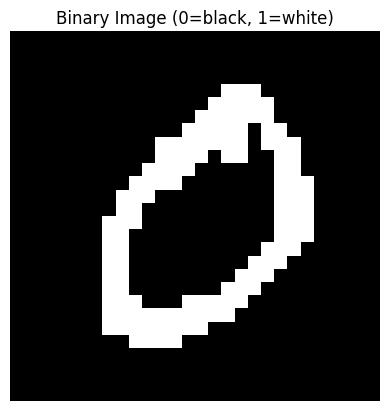

In [4]:
import matplotlib.pyplot as plt

# Convert images to black and white using a threshold of 128
train_X_bw = (train_X_small > 128).astype(int)

# Confirm the conversion by printing the first binary image as an example
print("First binary image representation (0=black, 1=white):")

plt.imshow(train_X_bw[0], cmap='gray')
plt.title("Binary Image (0=black, 1=white)")
plt.axis('off')  # Hide the axis for a cleaner look
plt.show()

Step 3: Calculate Final Unique Value Using Row-Wise and Column-Wise Approaches Combined

In [7]:
# Function to calculate combined row-wise and column-wise indices-based sum for an image
def calculate_combined_indices_sum(image):
    # Row-wise calculation
    row_sum = 0
    for row_index, row in enumerate(image):
        for col_index, pixel in enumerate(row):
            if pixel == 1:  # Only consider active pixels
                coefficient_row = (row_index + 1) * 10 + (col_index + 1)
                row_sum += coefficient_row

    # Column-wise calculation
    col_sum = 0
    for col_index in range(image.shape[1]):
        for row_index, pixel in enumerate(image[:, col_index]):
            if pixel == 1:  # Only consider active pixels
                coefficient_col = (row_index + 1) * 10 + (col_index + 1)
                col_sum += coefficient_col

    # Combined final value
    final_value = row_sum + col_sum
    return final_value

# Calculate the combined indices-based sum for each image in the subset
final_combined_sums = [calculate_combined_indices_sum(img) for img in train_X_bw]

# Print the combined indices-based sum for each digit in the subset
for digit, combined_sum in zip(train_y_small, final_combined_sums):
    print(f"Digit {digit}: Combined Indices-Based Sum = {combined_sum}")

Digit 0: Combined Indices-Based Sum = 40188
Digit 0: Combined Indices-Based Sum = 43526
Digit 0: Combined Indices-Based Sum = 46686
Digit 0: Combined Indices-Based Sum = 49524
Digit 0: Combined Indices-Based Sum = 57492
Digit 0: Combined Indices-Based Sum = 56834
Digit 0: Combined Indices-Based Sum = 61730
Digit 0: Combined Indices-Based Sum = 32594
Digit 0: Combined Indices-Based Sum = 55620
Digit 0: Combined Indices-Based Sum = 44066
Digit 1: Combined Indices-Based Sum = 22914
Digit 1: Combined Indices-Based Sum = 22172
Digit 1: Combined Indices-Based Sum = 15442
Digit 1: Combined Indices-Based Sum = 14024
Digit 1: Combined Indices-Based Sum = 21254
Digit 1: Combined Indices-Based Sum = 28184
Digit 1: Combined Indices-Based Sum = 19634
Digit 1: Combined Indices-Based Sum = 22178
Digit 1: Combined Indices-Based Sum = 18252
Digit 1: Combined Indices-Based Sum = 27656
Digit 2: Combined Indices-Based Sum = 37074
Digit 2: Combined Indices-Based Sum = 34524
Digit 2: Combined Indices-Based 